# Figure for paper:
## Heatmap for other deep lines


Author: Michael Gully-Santiago  
Date: Nov 21, 2022

Ok, let's experiment by looking for trends with other deep lines

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
from muler.hpf import HPFSpectrum
import seaborn as sns

from specutils.fitting import fit_continuum
from astropy.modeling import models

from astropy.time import Time
import lightkurve as lk
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper', font_scale=1.2)

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message="Model is linear in parameters")

In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

### Read in the table of metadata

In [3]:
import pyarrow.feather as feather

df = feather.read_feather('../../data/HPF/HAT_P_67_log.feather')

In [5]:
from astropy.time import Time
import astropy.units as u

## Post-process the spectra
Apply the same method to each spectrum.  We will define some continuum indices to flatten to.

Feature

In [6]:
f1, f2 = (10329, 10331)
feature_indices = (f1, f2)

Flattening

In [7]:
b1, b2 = (10321, 10323)
r1, r2 = (10357, 10359)

Overall region of interest

In [8]:
reg1, reg2 = (10320, 10360)

In [9]:
blue_limits = (b1*u.Angstrom, b2*u.Angstrom)
red_limits = (r1*u.Angstrom, r2*u.Angstrom)

window = [blue_limits, red_limits]

(0.0, 1.1)

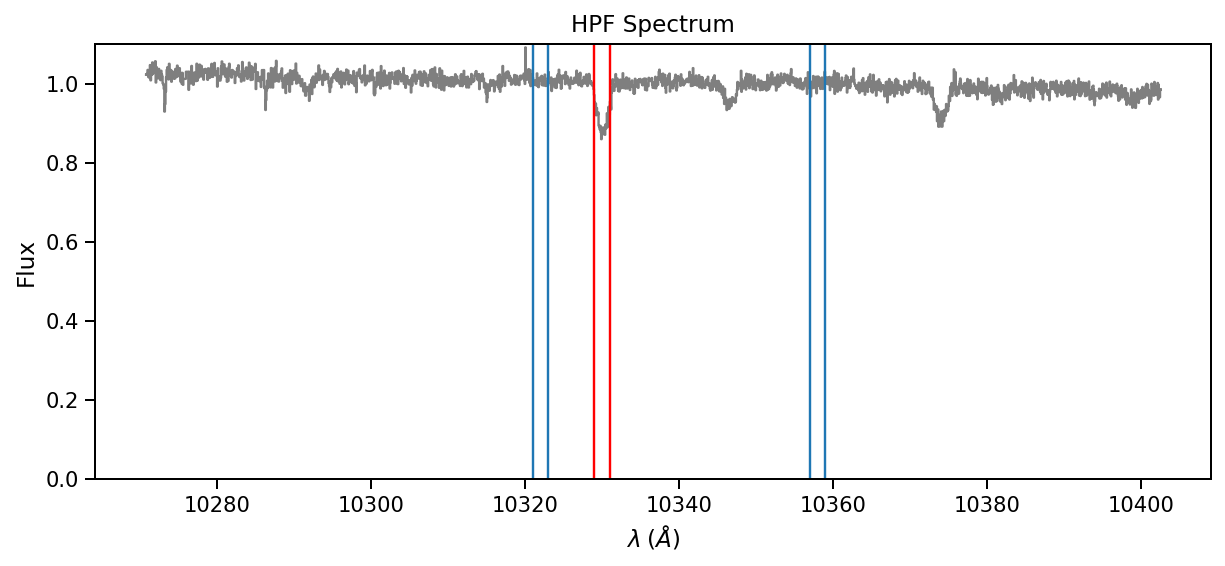

In [10]:
order=16

fn = df.iloc[0].full_path
spec_raw = HPFSpectrum(file=fn, order=order)
spec =  spec_raw.sky_subtract(method='vector')\
                .remove_nans()\
                .trim_edges()\
                .deblaze()\
                .mask_tellurics(threshold=0.95, dilation=3)\
                .barycentric_correct().normalize()

ax = spec.plot(color='k', alpha=0.5)

ax.axvline(b1)
ax.axvline(b2)
ax.axvline(r1)
ax.axvline(r2)
ax.axvline(f1, color='r')
ax.axvline(f2, color='r')
#ax.set_xlim(reg1, reg2)
ax.set_ylim(0.0, 1.1)

In [11]:
def flatten_to_regions(spec, windows, polynomial_order=None):
    """Flatten a spectrum to featureless continuum input regions
    
    Parameters:
    ----------
    spec (Spectrum1D-like):
        A spectrum to be flattened
    window (list of tuples):
        A list of pairs of boundaries at which the straight line will be computed
    polynomial_order (int):
        The polynomial order of the fit (defaults to 1-- straight line)
    """
    if polynomial_order is None:
        polynomial_order = 1
    linear_model = models.Chebyshev1D(polynomial_order)
    continuum_func = fit_continuum(spec, window=windows, model=linear_model)
    return spec/continuum_func(spec.wavelength)

In [12]:
spec_list = []
for fn in tqdm(df.full_path.values):
    spec_raw = HPFSpectrum(file=fn, order=order)
    spec =  spec_raw.sky_subtract(method='vector')\
                    .remove_nans()\
                    .trim_edges()\
                    .deblaze()\
                    .mask_tellurics(threshold=0.95, dilation=3)\
                    .barycentric_correct().normalize()
    spec = flatten_to_regions(spec, window)
    spec_list.append(spec)

  0%|          | 0/152 [00:00<?, ?it/s]

In [13]:
len(spec_list)

152

(0.6, 1.05)

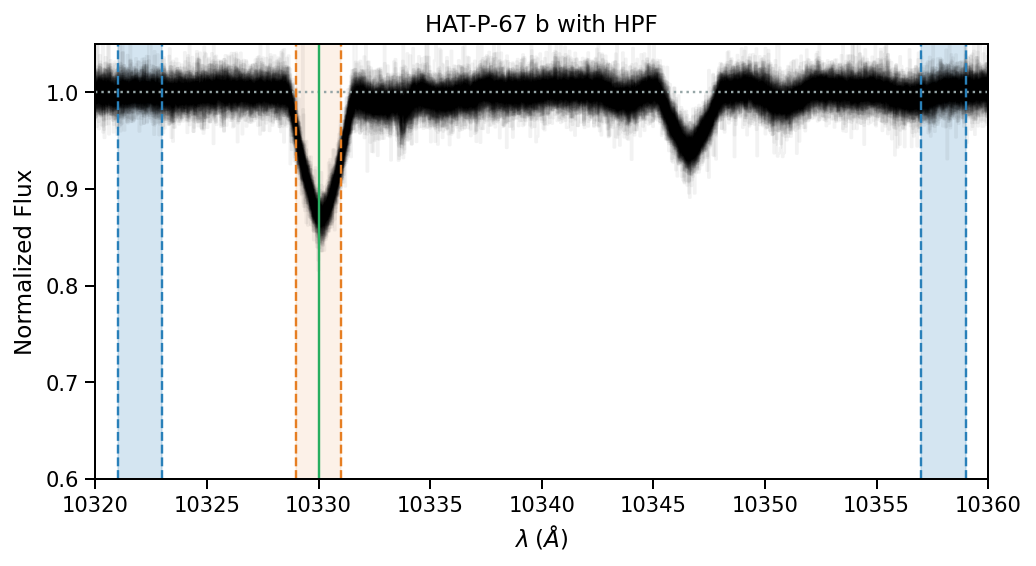

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

for spec in spec_list:
    spec.plot(ax=ax, ylo=0, color='k', alpha=0.05)


ax.set_xlim(reg1, reg2)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#e67e22')
ax.axvline(feature_indices[1], linestyle='dashed', color='#e67e22')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#e67e22', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')
ax.set_title('HAT-P-67 b with HPF')

ax.axvline(f1/2+f2/2, color='#27ae60')

ax.set_ylim(0.6, 1.05)
#plt.savefig('../../figures/HAT_P_67b_He_spectrum.png', bbox_inches='tight', dpi=300);

## 2D Phase plot

In [15]:
from muler.utilities import combine_spectra_misaligned

In [16]:
pixel_midpoints = spec_raw.wavelength.value

In [17]:
n_spec = len(spec_list)

In [18]:
xcs = np.array([])
ycs = np.array([])
zcs = np.array([])
for i in range(n_spec):
    spec = spec_list[i]
    x_coordinates = np.array(spec.wavelength.value)
    n_coords = len(x_coordinates)
    y_coordinates = np.repeat(df.normalized_phase[i], n_coords)
    z_coordinates = np.array(spec.flux.value)
    xcs = np.hstack([xcs, x_coordinates])
    ycs = np.hstack([ycs, y_coordinates])
    zcs = np.hstack([zcs, z_coordinates])

In [19]:
len(zcs)

308992

mask the arrays

In [20]:
x_mask = (xcs >reg1) & (xcs <reg2)

In [21]:
xcs, ycs, zcs = xcs[x_mask], ycs[x_mask], zcs[x_mask]

In [102]:
np.median(np.diff(spec.wavelength.value))

0.06469514143645938

In [103]:
x_digitized = np.arange(reg1, reg2, 0.1)

In [104]:
nx = len(x_digitized)
nx

400

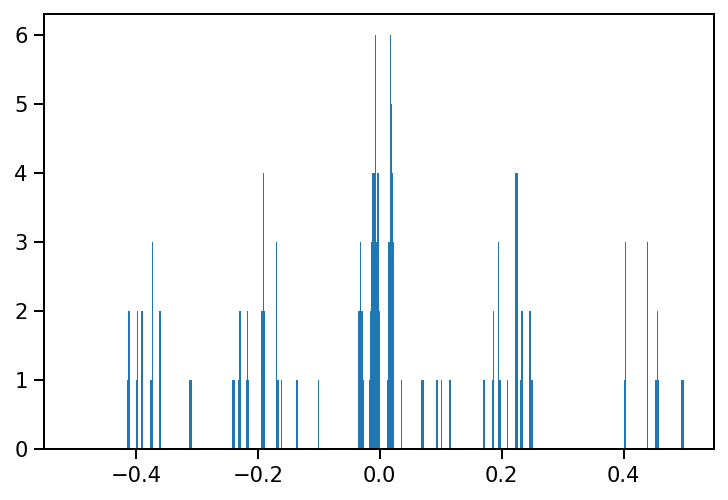

In [105]:
plt.hist(df.normalized_phase.values, bins=np.arange(-0.5, 0.5, 0.002));

In [147]:
y_digitized = np.arange(-0.5, 0.5, 0.002)

In [148]:
from scipy.sparse import coo_array

In [149]:
xcs_dig = np.digitize(xcs, x_digitized)
ycs_dig = np.digitize(ycs, y_digitized)

In [150]:
ny = len(y_digitized)
ny

500

In [151]:
# Constructing a array using ijv format
z_sparse_matrix = coo_array((zcs, (xcs_dig, ycs_dig)), shape=(nx+1, ny+1))
z_sparse_count = coo_array(((zcs>0).astype(np.int32), (xcs_dig, ycs_dig)), shape=(nx+1, ny+1))

In [152]:
z_sparse_matrix

<401x501 sparse array of type '<class 'numpy.float64'>'
	with 93553 stored elements in COOrdinate format>

In [153]:
z_sparse_count.sum_duplicates()

In [154]:
counts = z_sparse_count.toarray()

In [155]:
mask = counts == 0

In [156]:
counts[mask] = 1

In [157]:
z_dense_array = z_sparse_matrix.toarray()/counts

Get the planet speed versus phase relationship, assume circular orbit: 0 km/s at 0 phase

In [158]:
x_mesh, y_mesh = np.meshgrid(x_digitized, y_digitized)

In [159]:
semi_major_axis = 0.06505 * u.AU

In [160]:
target_name = 'HAT-P-67b'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c - 2457000.0 #neg value means discovered before TESS
t_14_hours = 6.989 # transit duration in hours
t_14_days = t_14_hours/24.0
t_14_orb_phase = t_14_days / orbital_period

In [161]:
planet_speed_quantity = (2*np.pi*semi_major_axis)/(orbital_period*u.day)
planet_speed_quantity.to(u.km/u.second)

<Quantity 147.1243333 km / s>

In [162]:
planet_speed = planet_speed_quantity.to(u.km/u.second).value

In [163]:
phase = np.arange(-0.5, 0.5, 0.001)

In [164]:
import astropy.constants as const

In [165]:
delta_v_over_c = (planet_speed_quantity/const.c).to(u.dimensionless_unscaled)

In [166]:
lam_0 = (f1+f2)/2

In [167]:
wavelength_shift =  lam_0 *(1 + delta_v_over_c * np.sin(2.0*np.pi*phase))

In [168]:
K_stellar = 36.0*u.meter/u.second
stellar_rv_shift = lam_0 - (K_stellar/const.c).to(u.dimensionless_unscaled)* np.sin(2.0*np.pi*phase) * lam_0

In [169]:
x_pixels = np.linspace(reg1, reg2, nx+1)
y_pixels = np.linspace(-0.5, 0.5, ny+1)

In [170]:
z_dense_array.shape

(401, 501)

In [171]:
extent = [reg1, reg2, -0.5, 0.5]

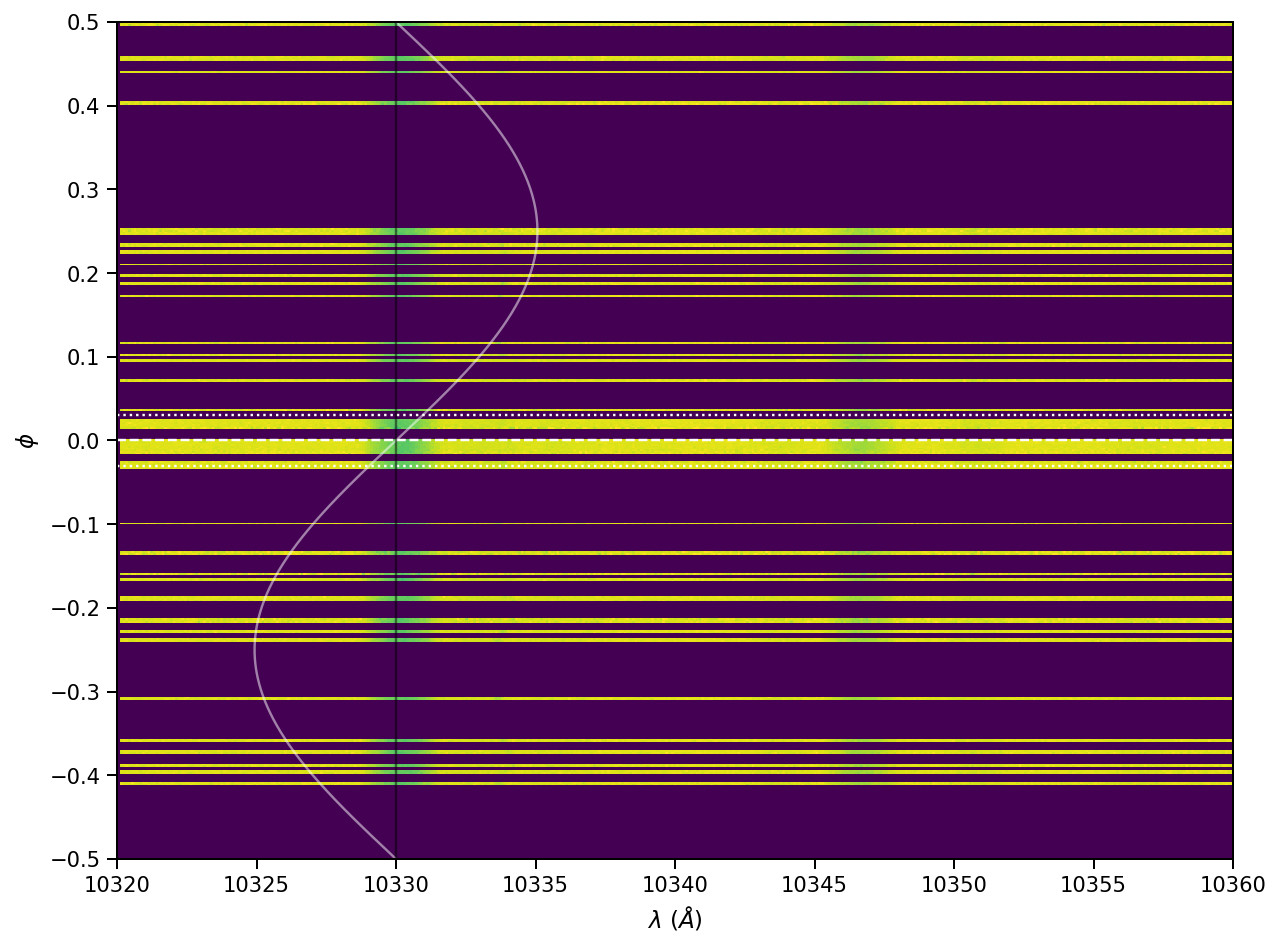

In [172]:
mask = z_dense_array!=z_dense_array
z_dense_array[mask] = 0

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(z_dense_array.T, origin='lower', 
           extent=extent, aspect=30, vmin=0.4, vmax=1.03, interpolation='none');
ax.set_xlabel(r'$\lambda~(\AA)$');
ax.set_ylabel('$\phi$')
ax.axhline(0, color='w', linestyle='dashed')
ax.axhline(-t_14_orb_phase/2, linestyle='dotted', color='w')
ax.axhline(+t_14_orb_phase/2, linestyle='dotted', color='w')

ax.set_yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.plot(wavelength_shift, phase, '-', color='w', alpha=0.5)
ax.plot(stellar_rv_shift, phase, '-', color='k', alpha=0.5)
#plt.savefig('../../paper/paper1/figures/phase_2D_diagram.png', dpi=300, bbox_inches='tight')

Let's subtract off the average low-flux spectrum:

In [173]:
baseline = combine_spectra_misaligned(spec_list, pixel_midpoints=x_pixels).flux.value

In [174]:
y_counts = (z_dense_array == z_dense_array) & (z_dense_array > 0) 

In [175]:
baseline_alt = np.nansum(z_dense_array, axis=1)/y_counts.sum(axis=1)

In [176]:
bad_mask = z_dense_array==0

In [177]:
#z_dense_array[bad_mask] = np.NaN

In [178]:
z_dense_array.T - baseline_alt[np.newaxis, :]

array([[            nan, -9.98448092e-01, -1.00011542e+00, ...,
        -1.00381196e+00, -1.00293446e+00, -1.00283098e+00],
       [            nan, -9.98448092e-01, -1.00011542e+00, ...,
        -1.00381196e+00, -1.00293446e+00, -1.00283098e+00],
       [            nan, -9.98448092e-01, -1.00011542e+00, ...,
        -1.00381196e+00, -1.00293446e+00, -1.00283098e+00],
       ...,
       [            nan,  9.85433247e-03, -5.83833500e-03, ...,
        -5.62572321e-03, -4.94043230e-03, -2.51666809e-02],
       [            nan, -1.54026385e-02,  6.29393852e-03, ...,
         7.81694489e-03, -8.50084702e-04, -5.39413068e-03],
       [            nan, -9.98448092e-01, -1.00011542e+00, ...,
        -1.00381196e+00, -1.00293446e+00, -1.00283098e+00]])

In [179]:
residual = (z_dense_array.T-baseline_alt)/baseline_alt*100

In [180]:
residual_finite = residual.copy()
zero_mask = z_dense_array.T == 0
residual_finite[zero_mask] = np.NaN

(-0.501, 0.501)

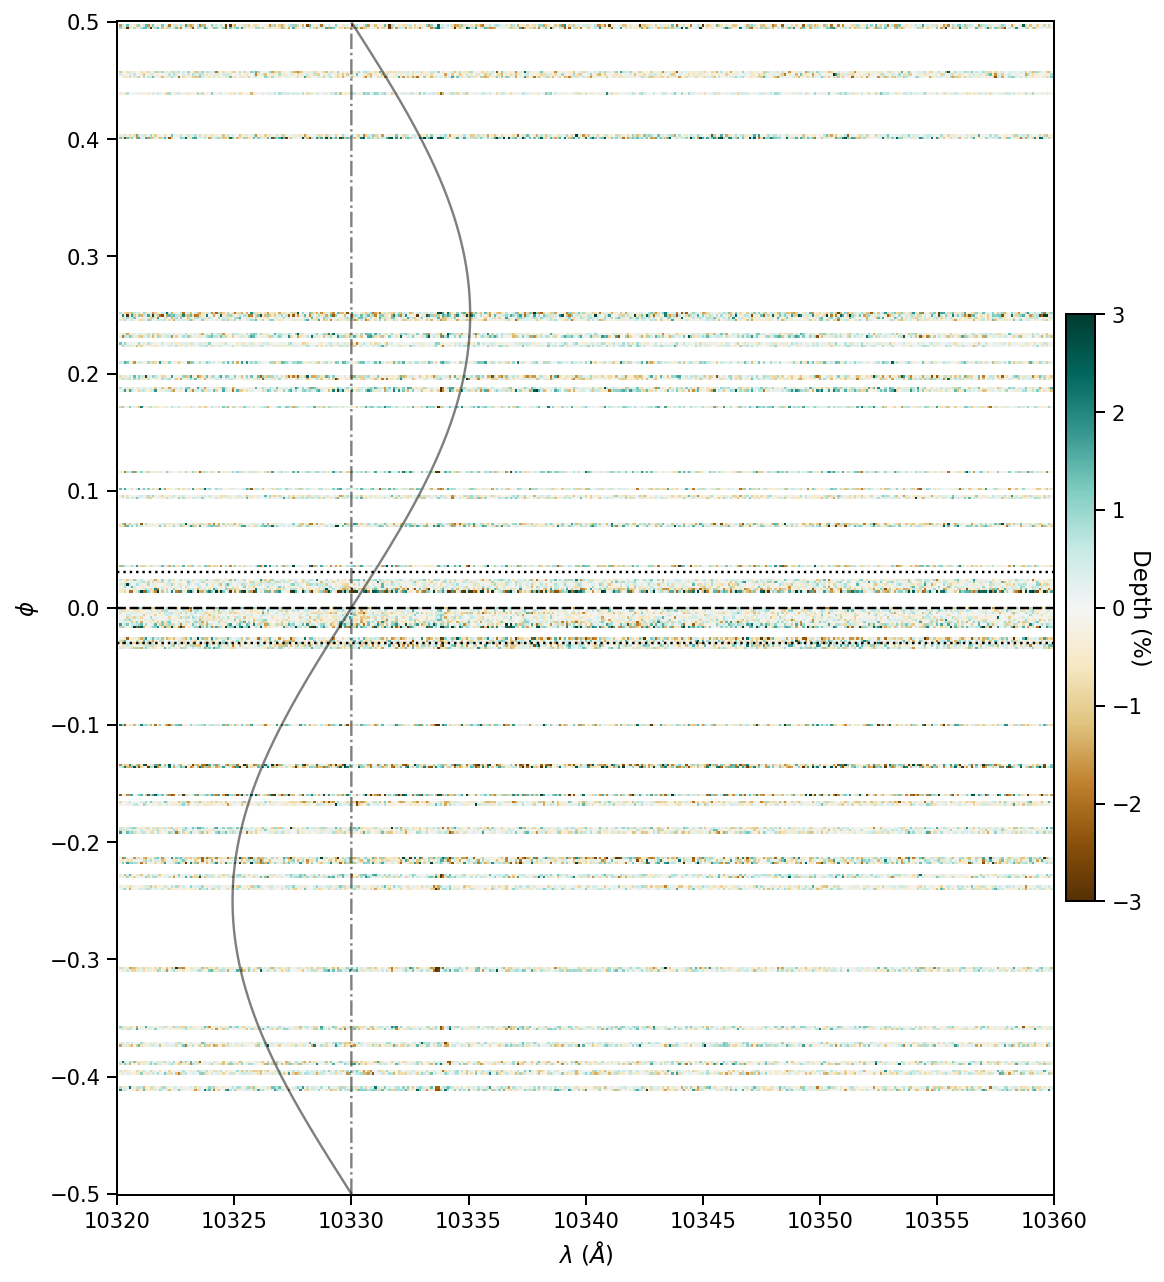

In [181]:
fig, ax = plt.subplots(figsize=(10, 18))
img = ax.imshow(residual_finite, origin='lower', cmap='BrBG',
           extent=extent, aspect=50, vmin=-3, vmax=3, interpolation='none');

cb = fig.colorbar(img, ax=ax, cmap='BrBG', pad=0.01, shrink=0.3)
cb.ax.set_ylabel('Depth (%)', rotation=270)
ax.set_xlabel(r'$\lambda~(\AA)$');
ax.set_ylabel('$\phi$')
ax.axhline(0, color='k', linestyle='dashed')
ax.axhline(-t_14_orb_phase/2, linestyle='dotted', color='k')
ax.axhline(+t_14_orb_phase/2, linestyle='dotted', color='k')

ax.set_yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])

#ax.text(10821.5, -0.15, 'Ingress', rotation=90, color='#95a5a6', size=12)
#ax.text(10821.5, +0.1, 'Egress', rotation=90, color='#95a5a6', size=12)

#ax.text(10824.5, -0.48, 'Blueshifted', rotation=0, color='#95a5a6', size=12)
#ax.text(10835.5, -0.48, 'Redshifted', rotation=0, color='#95a5a6', size=12)

ax.plot(wavelength_shift, phase, '-', color='k', alpha=0.5)
ax.plot(stellar_rv_shift, phase, '-.', color='k', alpha=0.5)
ax.set_ylim(-0.501,0.501)
#plt.savefig('../../paper/paper1/figures/Lam10330_phase_2D_diagram_resid.png', dpi=300, bbox_inches='tight')

Neat! No conspicuous signal?

### R-M experiment?

In [182]:
vsini_stellar = 35.8*u.km/u.second
vsini_shift_red = lam_0 * (1+ (vsini_stellar/const.c).to(u.dimensionless_unscaled))
vsini_shift_blue = lam_0 * (1- (vsini_stellar/const.c).to(u.dimensionless_unscaled))

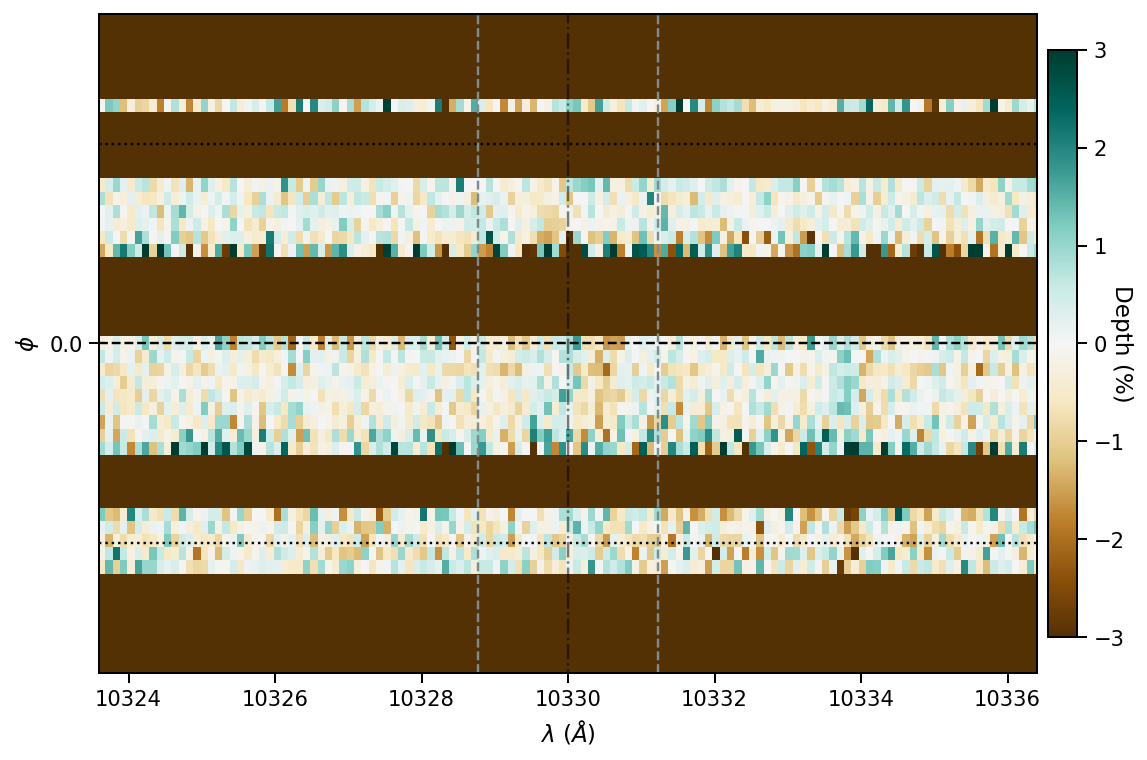

In [184]:
fig, ax = plt.subplots(figsize=(10, 18))
img = ax.imshow(residual, origin='lower', cmap='BrBG',
           extent=extent, aspect=90, vmin=-3, vmax=3);

cb = fig.colorbar(img, ax=ax, cmap='BrBG', pad=0.01, shrink=0.3)
cb.ax.set_ylabel('Depth (%)', rotation=270)
ax.set_xlabel(r'$\lambda~(\AA)$');
ax.set_ylabel('$\phi$')
ax.axhline(0, color='k', linestyle='dashed')
ax.axhline(-t_14_orb_phase/2, linestyle='dotted', color='k')
ax.axhline(+t_14_orb_phase/2, linestyle='dotted', color='k')

ax.set_yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])

#ax.text(10821.5, -0.15, 'Ingress', rotation=90, color='#95a5a6', size=12)
#ax.text(10821.5, +0.1, 'Egress', rotation=90, color='#95a5a6', size=12)

#ax.text(10824.5, -0.48, 'Blueshifted', rotation=0, color='#95a5a6', size=12)
#ax.text(10835.5, -0.48, 'Redshifted', rotation=0, color='#95a5a6', size=12)

#ax.plot(wavelength_shift, phase, '-', color='k', alpha=0.5)
ax.plot(stellar_rv_shift, phase, '-.', color='k', alpha=0.5)


ax.axvline(vsini_shift_blue, linestyle='dashed', color='#7f8c8d')
ax.axvline(vsini_shift_red, linestyle='dashed', color='#7f8c8d')

ax.set_xlim(vsini_shift_blue*0.9995, vsini_shift_red*1.0005)
ax.set_ylim(-0.05, 0.05)
plt.savefig('../../paper/paper1/figures/lam10330_RM_effect.png', dpi=300, bbox_inches='tight')

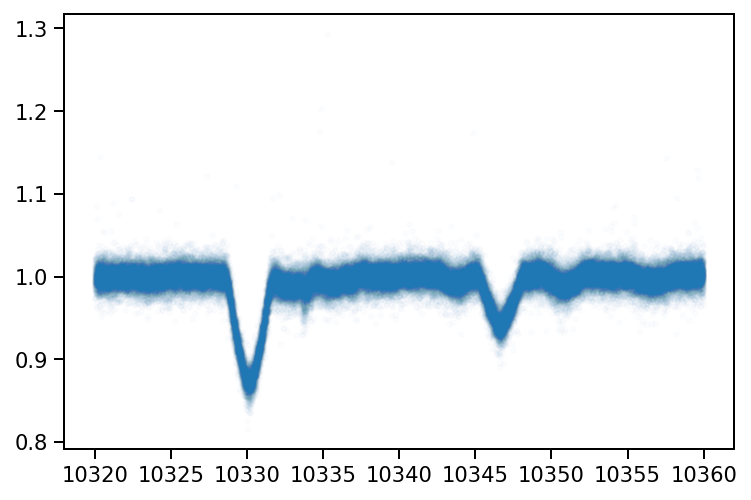

In [192]:
plt.plot(xcs, zcs, '.', alpha=0.01)

In [193]:
from scipy.stats import binned_statistic

In [196]:
result = binned_statistic(xcs, zcs, statistic=np.nanstd, bins=pixel_midpoints)

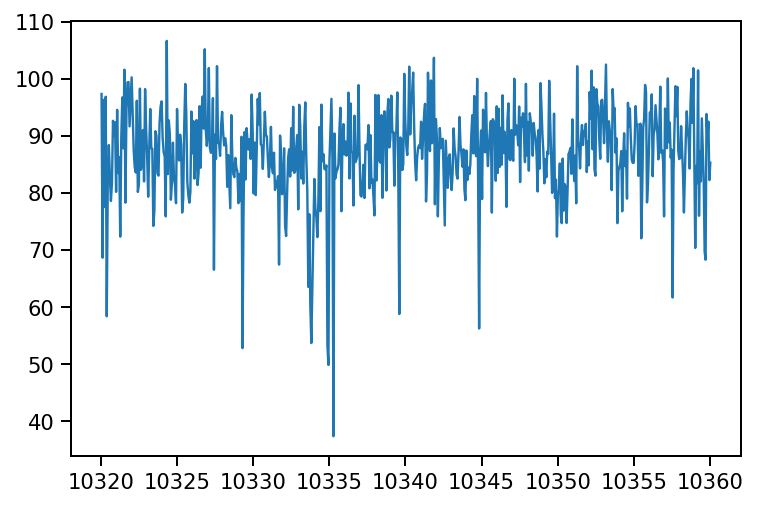

In [201]:
plt.plot(result.bin_edges[1:], 1/result.statistic)

In [209]:
df

,night_number,night_of,local_hour,ORIGIN,DATE,OBJECT,OBSERVER,OBSTYPE,DATE-OBS,CAL-OBJ,...,JD,BTJD,phase,normalized_phase,in_transit_flag,campaign,stddev_order19,RV_planet,track,in_transit_text
0,879,2020-04-26,1.49,astropy.fits,2020-04-27T06:28:47,HAT-P-67b_OUT_1_before1,CFB,Sci,2020-04-27T06:29:11.640106,dark,...,2.458967e+06,1966.770274,-0.928459,-0.193023,False,April 2022,0.016845,-137.796626,east,
1,879,2020-04-26,1.58,astropy.fits,2020-04-27T06:34:37,HAT-P-67b_OUT_1_before1,CFB,Sci,2020-04-27T06:35:03.305245,dark,...,2.458967e+06,1966.774344,-0.924389,-0.192177,False,April 2022,0.014170,-137.520592,east,
2,879,2020-04-26,1.68,astropy.fits,2020-04-27T06:40:29,HAT-P-67b_OUT_1_before1,CFB,Sci,2020-04-27T06:40:55.338979,dark,...,2.458967e+06,1966.778418,-0.920314,-0.191329,False,April 2022,0.017570,-137.240374,east,
3,879,2020-04-26,1.78,astropy.fits,2020-04-27T06:46:19,HAT-P-67b_OUT_1_before1,CFB,Sci,2020-04-27T06:46:47.563456,dark,...,2.458967e+06,1966.782495,-0.916238,-0.190482,False,April 2022,0.012987,-136.956114,east,
4,880,2020-04-27,1.18,astropy.fits,2020-04-28T06:10:02,HAT-P-67b_IN_1,CFB,Sci,2020-04-28T06:10:31.377897,dark,...,2.458968e+06,1967.757308,0.058575,0.012178,True,April 2020,0.027362,11.246033,east,in transit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,1688,2022-07-14,1.79,astropy.fits,2022-07-15T06:46:52,HAT-P-67b_P1_monitor_5,CFB,Sci,2022-07-15T06:47:13.670208,dark,...,2.459776e+06,2775.782797,-0.013155,-0.002735,True,P4,0.072020,-2.528089,west,in transit
148,1689,2022-07-15,2.21,astropy.fits,2022-07-16T07:12:06,HAT-P-67b_P1_monitor_5,CFB,Sci,2022-07-16T07:12:28.209621,dark,...,2.459777e+06,2776.800327,1.004374,0.208805,False,P4,0.071611,142.223444,west,
149,1693,2022-07-19,1.52,astropy.fits,2022-07-20T06:30:56,HAT-P-67b_P1_monitor_6,CFB,Sci,2022-07-20T06:31:17.989780,dark,...,2.459781e+06,2780.771736,0.165681,0.034444,False,P4,0.071831,31.592733,west,
150,1702,2022-07-28,0.78,astropy.fits,2022-07-29T05:46:37,HAT-P-67b_P1_monitor_8,CFB,Sci,2022-07-29T05:46:59.729116,dark,...,2.459790e+06,2789.740969,-0.485291,-0.100890,False,P4,0.073831,-87.141705,west,


In [213]:
len(df.groupby(['night_of', 'track']).QRA.count())

41